In [1]:
import pandas as pd
import numpy as np
import glob

In [2]:
def load(file):
    """Load the experiment data from a CSV file with converter metrics."""
    
    schema = {
        'num_threads': np.int64(),
        'num_jsons_converted': np.int64(),
        'num_json_bytes_converted': np.int64(),
        'num_ipc': np.int64(),
        'ipc_bytes': np.int64(),
        'num_buffers_converted': np.int64(),
        't_parse': np.float64(),
        't_resize': np.float64(),
        't_serialize': np.float64(),
        't_thread': np.float64(),
        't_enqueue': np.float64(),
        'status': np.int64()
    }
    
    df = pd.read_csv(file, dtype=schema)

    # Make sure there were no errors for converters.
    assert(df['status'].sum() == len(df.index))
        
    return df

In [3]:
def analyze(df):
    """Analyze the experiment data, deriving various metrics such as throughput."""
    # Calculate time spent within the thread as 'other'.
    df['t_other'] = df['t_thread'] - df[['t_parse', 't_resize', 't_serialize', 't_enqueue']].sum(axis=1)
    
    # Calculate throughput
    df['Throughput (in)'] = df['num_json_bytes_converted'] / df['t_thread']
    df['Throughput (out)'] = df['ipc_bytes'] / df['t_thread']
    
    df['Parse throughput (in)'] = df['num_json_bytes_converted'] / df['t_parse']
    
    return df

In [4]:
def summarize(df):
    """Summarize the data from all threads into one row."""
    
    # num_threads,num_jsons_converted,num_json_bytes_converted,num_ipc,ipc_bytes,
    # num_buffers_converted,t_parse,t_resize,t_serialize,t_thread,t_enqueue,status
    
    row = {'Threads': df['num_threads'].sum(),
             'JSONs': df['num_jsons_converted'].sum(), 
             'Bytes (in)': df['num_json_bytes_converted'].sum(), 
             'IPC messages': df['num_ipc'].sum(),
             'IPC bytes': df['ipc_bytes'].sum(),
             'Buffers converted': df['num_buffers_converted'].sum(), 
             # Take the mean of the time spent in threads:
             'Parse time': df['t_parse'].mean(),
             'Resize time': df['t_resize'].mean(), 
             'Serialize time': df['t_serialize'].mean(), 
             'Enqueue time': df['t_enqueue'].mean(), 
             'Other time': df['t_other'].mean(),
             'Thread time': df['t_thread'].mean(), 
             'Throughput (in)': df['Throughput (in)'].sum(),
             'Throughput (out)': df['Throughput (out)'].sum(),
             'Parse throughput (in)': df['Parse throughput (in)'].sum()}
              
    return row;

In [5]:
def get_all_data(schema, impl):
    csv_files = []
    for file in glob.glob("../experiments/data/{}/latency/threads/metrics/{}/*.csv".format(schema, impl)):
        csv_files.append(file)

    records = []
    for file in csv_files:
        records.append(summarize(analyze(load(file))))


    df = pd.DataFrame.from_records(records)

    df.sort_values(by=['Threads', 'JSONs'], inplace=True)
    return df

In [6]:
def get_max_throughput_for_max_size(schema, impl):
    df = get_all_data(schema, impl)
    df = df[df.JSONs == df.JSONs.max()]
    #df.set_index('Threads', inplace=True)

    result = df[df['Parse throughput (in)'] == df['Parse throughput (in)'].max()]
    result.insert(0,'Implementation',impl)

    return result

In [7]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 14
})

,Implementation,Threads,JSONs,Bytes (in),IPC messages,IPC bytes,Buffers converted,Parse time,Resize time,Serialize time,Enqueue time,Other time,Thread time,Throughput (in),Throughput (out),Parse throughput (in)
78,arrow,10,32075776,8589870016,320,0,320,20.600280,0.000020,0.000035,0.000057,5.761207,26.361600,3.258478e+08,0.0,4.173627e+08
78,custom,10,32075776,8589870016,320,0,320,3.854149,0.000023,0.000065,0.000131,1.621826,5.476194,1.568584e+09,0.0,2.231476e+09


<AxesSubplot:xlabel='Implementation'>

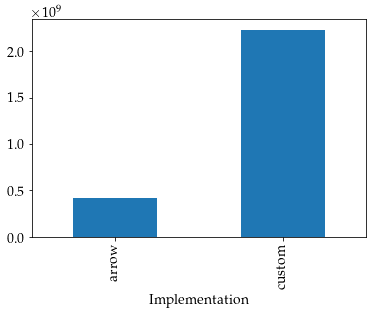

In [8]:
d_arrow = get_max_throughput_for_max_size('battery', 'arrow')
d_custom = get_max_throughput_for_max_size('battery', 'custom')
#d_fpga = get_max_throughput('battery', 'fpga')
df = pd.concat([d_arrow, d_custom]) #, d_fpga
display(df)

df = df.set_index('Implementation')
df = df['Parse throughput (in)']

df.plot.bar()